In [1]:
import numpy as np
import torch
import pandas as pd
import odbo
import os
import gc

In [31]:
random_seed = 0
np.random.seed(random_seed)
data_test = pd.read_csv('../datasets/BRCA1_2013_98299.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), 2**np.array(data_test['Log2Eratio'])

del data_test
if os.path.isfile('sele_indices_BRCA1_2013.npy') == True:
    sele_indices = np.load('sele_indices_BRCA1_2013.npy')
    shuffle_order = np.load('shuffle_order_BRCA1_2013.npy')
    name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
    name = odbo.utils.code_to_array(name_pre)    
else:
    shuffle_order = np.arange(len(Y_test))
    np.random.shuffle(shuffle_order[1:])
    np.save('shuffle_order_BRCA1_2013.npy', shuffle_order)
    name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
    name = odbo.utils.code_to_array(name_pre)
    sele_indices = odbo.initialization.initial_design(name, least_occurance=np.ones(102),allow_abundance=True,update_method='correlate',verbose=True)
    np.save('sele_indices_BRCA1_2013.npy', sele_indices)
name_sele, Y_train = name[sele_indices, :], Y_test[sele_indices]
ids_keep = np.delete(range(len(Y_test)), sele_indices)
name, Y_test = name[ids_keep, :], Y_test[ids_keep]
print('Selected initial experiments no. is ', len(Y_train))
print('Select max Y: ', Y_train.max(), 'True max Y:', Y_test.max())


Selected initial experiments no. is  688
Select max Y:  20.53972883152061 True max Y: 511.15063402824103


In [33]:
feature_model = odbo.featurization.FewFeatureTransform(raw_vars=name_sele, Y=Y_train, method='Avg', mode='independent')
X_test = feature_model.transform(name)
X_train = feature_model.transform(name_sele)

## Random selection

In [4]:
sele_Y = list(np.random.choice(Y_test, 50, replace = False))
Y_train_sele = list(Y_train.copy())
Y_train_sele.extend(sele_Y)
print('Max Y', max(sele_Y))
np.save('results/BRCA1_2013/BRCA1_2013_random_{}.npy'.format(random_seed), Y_train_sele)

Max Y 9.401069041358214


3.0466427453460327
[21:02:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Correct ratio: 94.148%
FN ratio: 1.341%
FP ratio: 4.511%


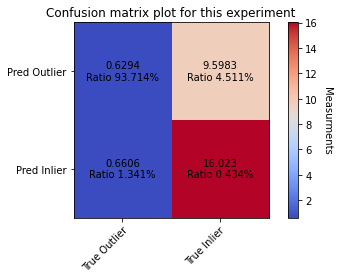

In [34]:
# Find the adaptive search space model
threshold = Y_train[np.argsort(Y_train)[int(0.98*len(Y_train))]]
print(threshold)
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error', random_state = random_seed)
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=threshold)
pred_test_labels = pre_model.predict(X_test)
# Plot the confusion matrix to check the accuracy of search space prescreening
out_outlier, in_outlier, out_inlier, in_inlier = odbo.plot.plot_cm(labels_test, pred_test_labels, Y_test)
print("Correct ratio: {0:.3%}".format((len(out_outlier)+len(in_inlier))/len(labels_test)))
print("FN ratio: {0:.3%}".format(len(out_inlier)/len(labels_test)))
print("FP ratio: {0:.3%}".format(len(in_outlier)/len(labels_test))) 

## ODBO, BO

## ODBO, TuRBO

In [ ]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
sele_id_test = list(np.where(pred_test_labels == 0)[0])
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
print('Prscreening size:', len(sele_id_test))

# Run BO experiment with robust regression or directly GP
l, search_iter = 0, 50
gp_method='gp_regression'
tr_length = [3.2]
batch_size = 1
failure_count,max_count = 0,0
state = odbo.turbo.TurboState(dim=X_train_sele.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = 10)
state.best_value = Y_train_sele.max()
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), 'TR length: ', state.length, "Test max: ", Y_test_sele.max().detach().numpy())
    sele_feat = []
    for i in range(X_train_sele.shape[1]):
        if (X_train_sele[:,i]-X_train_sele[0,i]).any() !=0:
            sele_feat.append(i)
#    top_ids = np.argsort(Y_train_sele.numpy().ravel())[-200-l:]
    X_sele = X_train_sele[:,sele_feat]
    X_next, acq_value, raw_next_exp_id = odbo.turbo_design(state=state, X=X_sele, Y=Y_train_sele, X_pending=X_test_sele[:, sele_feat], n_trust_regions=len(tr_length), batch_size=batch_size, gp_method=gp_method)
    Y_next_m = torch.zeros((len(tr_length), batch_size, 1), device=Y_train_sele.device, dtype=Y_train_sele.dtype)
    next_exp_id = []
    for i in range(batch_size):
        next_exp_id_m = raw_next_exp_id[:, i]
        Y_next_m[:, i, 0], idtoadd = Y_test_sele[next_exp_id_m].reshape(len(tr_length)), next_exp_id_m[np.argmax(Y_test_sele[next_exp_id_m])]
        next_exp_id.append(idtoadd)
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_test_sele, Y_test_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), name_sele_temp[-1])
    state = odbo.turbo.update_state(state=state, Y_next=Y_next_m)
    feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method = 'Max', mode='independent')
    if Y_train_sele[-batch_size:].detach().numpy().max() <= Y_train_sele[:-batch_size].max():
        failure_count = failure_count + 1
    else:
        failure_count = 0
    if failure_count >= 3 and max_count < 3:
        max_count = max_count + 1
        feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method = 'Avg', mode='independent')
    else:
        max_count = 0
    X_test_sele= torch.tensor(feature_model1.transform(search_name_sele))
    X_train_sele = torch.tensor(feature_model1.transform(name_sele_temp))

    l = l + 1
np.save('results/BRCA1_2013/BRCA1_2013_ODBO_TuRBO_GP_batch1_{}.npy'.format(random_seed), Y_train_sele)



Prscreening size: 1733
Iter:  0 Current Max:  20.53972883152061 TR length:  [3.2] Test max:  511.15063402824103
Newly added value:  [[0.64280814]] ['L' 'E' 'K' 'F' 'K' 'L' 'L' 'A' 'E' 'K' 'V' 'E' 'E' 'N' 'V' 'A' 'K' 'N'
 'A' 'R' 'A' 'E' 'I' 'D' 'Y' 'S' 'D' 'A' 'P' 'D' 'E' 'F' 'R' 'D' 'P' 'L'
 'M' 'D' 'T' 'L' 'M' 'T' 'D' 'P' 'V' 'R' 'L' 'P' 'S' 'G' 'T' 'V' 'M' 'D'
 'R' 'S' 'I' 'I' 'L' 'R' 'H' 'L' 'L' 'N' 'S' 'P' 'T' 'D' 'P' 'F' 'N' 'R'
 'Q' 'M' 'L' 'T' 'E' 'S' 'M' 'L' 'E' 'P' 'V' 'P' 'E' 'L' 'K' 'E' 'Q' 'I'
 'Q' 'A' 'W' 'M' 'R' 'E' 'K' 'Q' 'S' 'S' 'D' 'H']
Iter:  1 Current Max:  20.53972883152061 TR length:  [3.2] Test max:  511.15063402824103
Newly added value:  [[0.56245712]] ['L' 'E' 'K' 'F' 'K' 'L' 'L' 'A' 'E' 'K' 'V' 'E' 'E' 'I' 'V' 'A' 'K' 'N'
 'A' 'R' 'A' 'E' 'I' 'D' 'Y' 'S' 'D' 'A' 'P' 'D' 'E' 'F' 'R' 'D' 'P' 'L'
 'M' 'D' 'T' 'L' 'M' 'T' 'D' 'P' 'V' 'R' 'L' 'P' 'S' 'G' 'T' 'V' 'M' 'D'
 'R' 'S' 'I' 'I' 'L' 'R' 'H' 'L' 'L' 'N' 'S' 'P' 'T' 'D' 'P' 'F' 'N' 'R'
 'Q' 'M' 'L' 'T' 'E' '